In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime
from dateparser import parse

In [5]:
from datetime import datetime, timedelta

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

In [7]:
sys.path.append("../code/")

In [8]:
import src

### parameters for papermill 

In [9]:
NZ_regions = ['NNI','WNI','ENI','NSI','WSI','ESI']
region = "NZ"
dpath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
shapes_path = "/home/nicolasf/operational/OISST_indices/data/shapefiles/"
ndays_agg = 1
nmonths_back = 24
quantile = 0.9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
dpath = pathlib.Path(dpath).joinpath(region)
clim_path = pathlib.Path(clim_path).joinpath(region)
shapes_path = pathlib.Path(shapes_path)

### get the current date 

In [11]:
current_date = datetime.utcnow()

In [12]:
first_day = parse(f'two {nmonths_back} months ago GMT')

In [13]:
first_day = first_day - timedelta(days=first_day.day - 1)

In [14]:
first_day

datetime.datetime(2020, 8, 1, 4, 0, 8, 393945, tzinfo=<StaticTzInfo 'GMT'>)

## get the years to read 

In [15]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [16]:
lfiles = [dpath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

## opens the near realtime dataset 

In [17]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords")

In [18]:
dset

<xarray.Dataset>
Dimensions:  (time: 951, lat: 80, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2022-08-08
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(366, 80, 72), meta=np.ndarray>

In [19]:
dset = dset.sel(time=slice(first_day, None))

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/core/indexes.py:150: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  indexer = index.slice_indexer(


In [20]:
last_day = pd.to_datetime(dset.time.data[-1])

### get rid of the 29th of Feb if present 

In [21]:
dset = dset.convert_calendar("noleap")

### opens the climatology 

In [22]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{region}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [23]:
clim

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, dayofyear: 365, quantile: 5)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
Data variables:
    average    (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>
    quantiles  (dayofyear, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>

### calculate the anomalies with respect to the 1991-2020 average

In [24]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

### repeat the climatology over the time dimension 

In [25]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [26]:
clim_repeat

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, time: 737, quantile: 5)
Coordinates:
    dayofyear  (time) int64 214 215 216 217 218 219 ... 215 216 217 218 219 220
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
  * time       (time) object 2020-08-02 00:00:00 ... 2022-08-08 00:00:00
Data variables:
    average    (lat, lon, time) float32 dask.array<chunksize=(20, 36, 152), meta=np.ndarray>
    quantiles  (time, quantile, lat, lon) float64 dask.array<chunksize=(63, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, time) float32 dask.array<chunksize=(20, 36, 152), meta=np.ndarray>

### derive the mask 

In [27]:
heatwave_mask = dset["sst"].where(dset["sst"] >= clim_repeat["quantiles"].sel(quantile=quantile))
heatwave_mask = heatwave_mask.where(np.isnan(heatwave_mask), other=1)

In [28]:
dset

<xarray.Dataset>
Dimensions:  (time: 737, lat: 80, lon: 72)
Coordinates:
  * time     (time) object 2020-08-02 00:00:00 ... 2022-08-08 00:00:00
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(152, 80, 72), meta=np.ndarray>

In [29]:
anoms

<xarray.Dataset>
Dimensions:    (time: 737, lat: 80, lon: 72)
Coordinates:
  * time       (time) object 2020-08-02 00:00:00 ... 2022-08-08 00:00:00
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
    dayofyear  (time) int64 214 215 216 217 218 219 ... 215 216 217 218 219 220
Data variables:
    sst        (time, lat, lon) float32 dask.array<chunksize=(152, 20, 36), meta=np.ndarray>

In [30]:
l_masks = []

for NZ_region in NZ_regions: 
    
    mask = src.make_mask_from_shape(shapes_path.joinpath(f'{NZ_region}_buffered_50km.shp'), dset, to_crs='EPSG:4326', mask_name=NZ_region) 
    
    l_masks.append(mask)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [31]:
NZ_regions_masks = xr.merge(l_masks)

### Now merge the masks with the anomalies, the raw data and the climatology 

In [32]:
anoms = anoms.merge(NZ_regions_masks)

In [33]:
dset = dset.merge(NZ_regions_masks)

In [34]:
clim_repeat = clim_repeat.merge(NZ_regions_masks)

### Now calculates the average anomalies 

##### Note: The regional averages of the anomalies is the same as the regional averages of the raw values minus the regional averages of the climatological average

In [35]:
anoms_ts = []

for NZ_region in NZ_regions: 
    
    anom_ts = (anoms['sst'] * anoms[NZ_region]).mean(['lat','lon'])
    
    anom_ts.name = f"SST_anomalies_{NZ_region}"
    
    anoms_ts.append(anom_ts)

In [36]:
anoms_ts = xr.merge(anoms_ts)

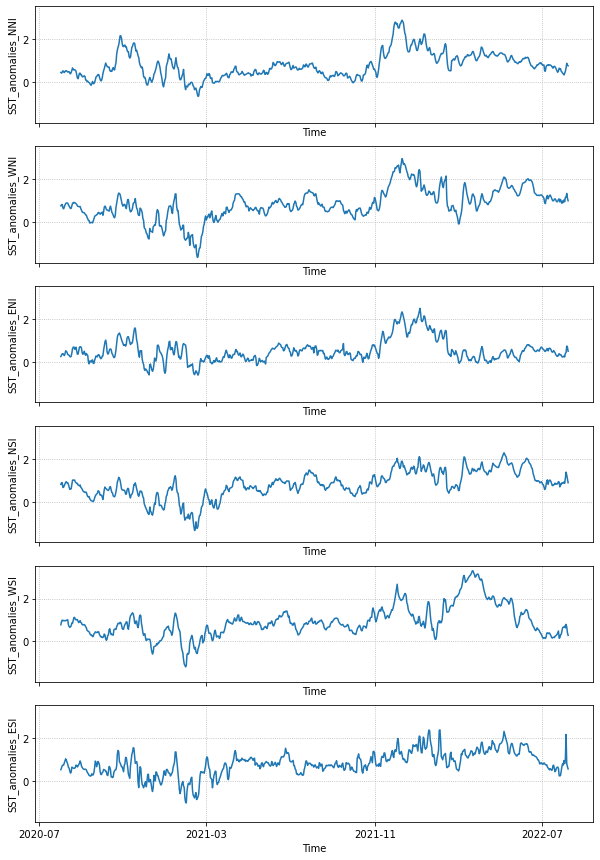

In [37]:
f, axes = plt.subplots(nrows=len(NZ_regions), figsize=(10,15), sharex=True, sharey=True)

for i, NZ_region in enumerate(NZ_regions): 
    
    anoms_ts[f'SST_anomalies_{NZ_region}'].plot(ax=axes[i])
    
    axes[i].grid(ls=':')

In [38]:
anoms_ts_monthly = anoms_ts.resample({'time':'1M'}).mean('time')

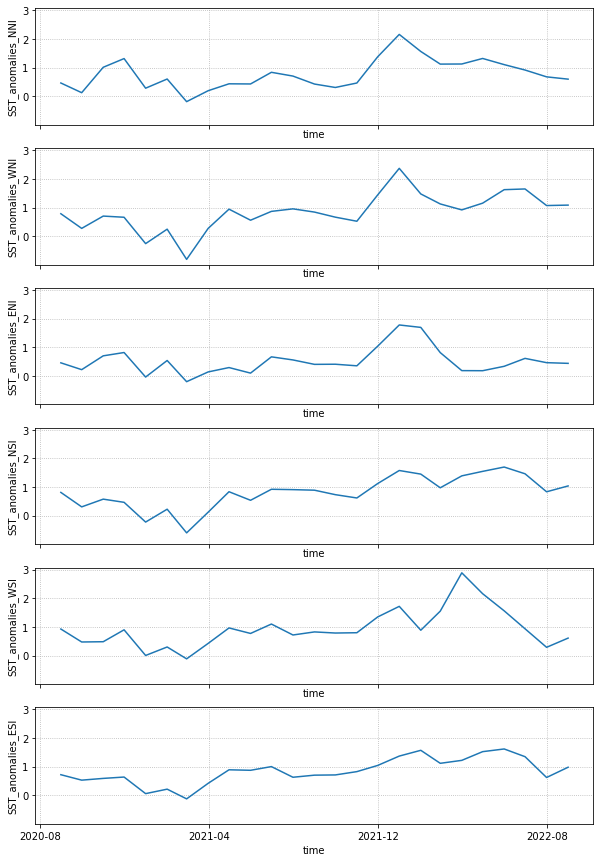

In [39]:
f, axes = plt.subplots(nrows=len(NZ_regions), figsize=(10,15), sharex=True, sharey=True)

for i, NZ_region in enumerate(NZ_regions): 
    
    anoms_ts_monthly[f'SST_anomalies_{NZ_region}'].plot(ax=axes[i])
    
    axes[i].grid(ls=':')

In [40]:
anoms_ts

<xarray.Dataset>
Dimensions:            (time: 737)
Coordinates:
  * time               (time) object 2020-08-02 00:00:00 ... 2022-08-08 00:00:00
    dayofyear          (time) int64 214 215 216 217 218 ... 216 217 218 219 220
Data variables:
    SST_anomalies_NNI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_WNI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_ENI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_NSI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_WSI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_ESI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>

### create a regular calendar 

In [41]:
standard_calendar = xr.DataArray({'time':pd.date_range(start=f"{first_day:%Y-%m-%d}", end=f"{last_day:%Y-%m-%d}")})

In [42]:
standard_calendar

<xarray.DataArray ()>
array({'time': DatetimeIndex(['2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10',
               ...
               '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06',
               '2022-08-07', '2022-08-08'],
              dtype='datetime64[ns]', length=738, freq='D')}, dtype=object)

In [44]:
anoms_ts.convert_calendar()

<xarray.Dataset>
Dimensions:            (time: 737)
Coordinates:
  * time               (time) object 2020-08-02 00:00:00 ... 2022-08-08 00:00:00
    dayofyear          (time) int64 214 215 216 217 218 ... 216 217 218 219 220
Data variables:
    SST_anomalies_NNI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_WNI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_ENI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_NSI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_WSI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>
    SST_anomalies_ESI  (time) float64 dask.array<chunksize=(152,), meta=np.ndarray>